<a href="https://colab.research.google.com/github/cyprus09/DenoisingAutoencoders/blob/main/Stacked_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 10.1 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import zipfile
import cv2
import time
from keras.datasets import cifar10
import py7zr
import tensorflow.compat.v1 as tf

In [ ]:
with py7zr.SevenZipFile('/content/train.7z', 'r') as archive:
    archive.extractall()

In [ ]:
def plot_images(img):
  fig, axes = plt.subplots(2,8, figsize = (13,3))
  for i in range(8):
    axes[0,i].imshow(img[i])
    axes[0,i].axis("off")
    axes[1,i].imshow(img[i+8])
    axes[1,i].axis("off")

(50000, 32, 32, 3)


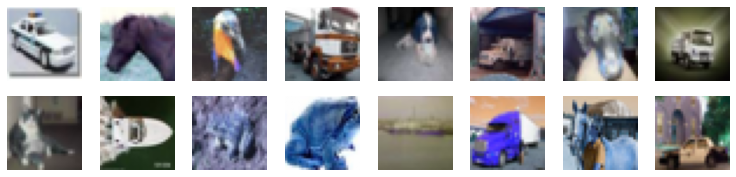

In [ ]:
img_database = []
base_path = "/content/"
cartoon = base_path +"train/"

for img in os.listdir(cartoon):
  try:
    img_array = cv2.imread(os.path.join(cartoon, img))
    img_database.append(img_array)

  except Exception as e:
    pass

img_database = np.array(img_database)

print(img_database.shape)

total_num_images = 2000

img_database = np.array(img_database[0:total_num_images])

orig_img = img_database.astype("float32")

orig_img = orig_img/255

plot_images(orig_img)

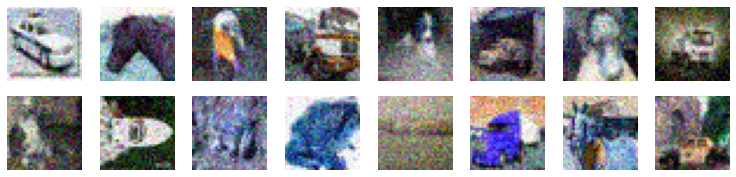

In [ ]:
orig_img_noisy = orig_img + 0.1* np.random.normal(loc = 0.0, scale = 1.0, size = orig_img.shape)
orig_img_noisy = np.clip(orig_img_noisy, 0,1)
plot_images(orig_img_noisy)

In [ ]:
X_T = np.transpose(orig_img, (0,3,1,2))
X_T_noise = np.transpose(orig_img_noisy, (0,3,1,2))

X_flat = X_T.reshape(-1, 1024)
X_flat_noise = X_T_noise.reshape(-1,1024)

In [ ]:
learning_rate = 0.001
training_epochs = 10000
batch_size = 100
display_step = 100
examples_to_show = 8

n_hidden_1 = 512
n_hidden_2 = 256
n_hidden_3 = 128
n_input = 1024

In [ ]:
tf.disable_v2_behavior()

X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_input])

weights = {
    'encoder_h1' : tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev = 0.01)),
    'encoder_h2' : tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev = 0.01)),
    'encoder_h3' : tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3], stddev = 0.01)),
    'decoder_h1' : tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_2], stddev = 0.01)),
    'decoder_h2' : tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1], stddev = 0.01)),
    'decoder_h3' : tf.Variable(tf.truncated_normal([n_hidden_1, n_input], stddev = 0.01))
    }

biases = {
    'encoder_b1' : tf.Variable(tf.truncated_normal([n_hidden_1], stddev = 0.01)),
    'encoder_b2' : tf.Variable(tf.truncated_normal([n_hidden_2], stddev = 0.01)),
    'encoder_b3' : tf.Variable(tf.truncated_normal([n_hidden_3], stddev = 0.01)),
    'decoder_b1' : tf.Variable(tf.truncated_normal([n_hidden_2], stddev = 0.01)),
    'decoder_b2' : tf.Variable(tf.truncated_normal([n_hidden_1], stddev = 0.01)),
    'decoder_b3' : tf.Variable(tf.truncated_normal([n_input], stddev = 0.01))
    }

def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases["encoder_b1"]))
    layer_2 =  tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                    biases["encoder_b2"]))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases["encoder_b3"]))
    return layer_3

def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases["decoder_b1"]))
    layer_2 =  tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                    biases["decoder_b2"]))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases["decoder_b3"]))
    return layer_3


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

y_pred = decoder_op

cost = tf.reduce_mean(tf.pow(Y-y_pred,2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
start = time.time()
total_batch = int(X_flat.shape[0]/batch_size)
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
  start = 0;end = batch_size
  for i in range(total_batch-1):
    index = np.arange(start, end)
    np.random.shuffle(index)
    batch_xs = X_flat[index]
    batch_xsn = X_flat_noise[index]
    start = end; end = start+batch_size

    _, c = sess.run([optimizer, cost], feed_dict  = {X: batch_xsn, Y:batch_xs})

if(epoch%1000 == 0):
    print('Epoch: {0:05d}  loss: {1:f}'.format(epoch, c))

print("Optimization Finished!")
end = time.time()
print("Time taken: {0}".format(end-start))

index = np.random.randint(orig_img.shape[0], size=examples_to_show)
print(index)
index = np.sort(index)
print(index)
RGB_index = np.concatenate((index*3, index*3+1, index*3+2))
print(RGB_index)
RGB_index = np.sort(RGB_index)
print(RGB_index)
denoised_image = sess.run(y_pred, feed_dict = {X: X_flat_noise[RGB_index]})

denoised_image = np.reshape(denoised_image, (examples_to_show, 3,32,32))
print(denoised_image.shape)
denoised_image = np.transpose(denoised_image(0,2,3,1))
print(denoised_image.shape)

f, a = plt.subplots(3, examples_to_show, figsize=(13,5))
for i in range(examples_to_show):
  a[0][i].imshow(orig_img[index[i]])
  a[0, i].axis('off')
  a[1][i].imshow(orig_img_noisy[index[i]])
  a[1, i].axis('off')
  a[2, i].imshow(denoised_image[i])
  a[2, i].axis('off')
f.show()
plt.draw()

def plot_max_active(x):

  fig, axes = plt.subplots(nrows=10, ncols = 10, figsize=(13,10))
  fig.subplots_adjust(hspace=.1, wspace = 0)
  img_h = img_w = np.sqrt(x.shape[0]).astype(int)
  for i, ax in enumerate(axes.flat):
    ax.imshow(x[:, i].reshape((img_h, img_w)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
  plt.show()

  plot_max_active(sess.run(weights["encoder_h1"]))
